In [1]:
!pip install diffusers torch transformers accelerate

Device set to use cuda:0


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Enter a detailed description: A beautiful sunset over the ocean with vibrant colors in the sky and gentle waves rolling on the shore


  0%|          | 0/50 [00:00<?, ?it/s]

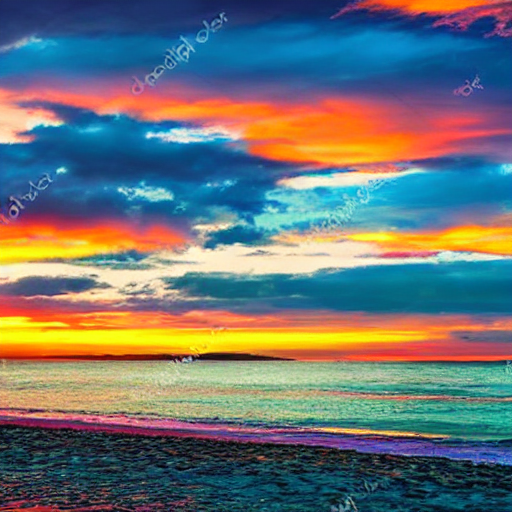

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Image saved at /content/generated_images/generated_image_A_beautifu.png

Generated Caption: A breathtaking view of color, waves, sunset during the day.
Generated Hashtags: #sunset #nature #ocean #sky #beauty #calmocean #vibrantcolors #oceanwaves


In [54]:
from transformers import pipeline, GPT2LMHeadModel, GPT2Tokenizer
from sentence_transformers import SentenceTransformer
import torch
from diffusers import StableDiffusionPipeline
from IPython.display import display
from PIL import Image
import os
import random

# Initialize pre-trained models
caption_generator = pipeline("text-generation", model="gpt2")

# Initialize Sentence Transformer for semantic keyword extraction
sentence_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Preload the Stable Diffusion model to optimize performance
model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id)
pipe.to("cuda" if torch.cuda.is_available() else "cpu")

# Cache directory for saving images
cache_dir = '/content/generated_images'
os.makedirs(cache_dir, exist_ok=True)

# Function to generate and save an image based on the detailed description provided by the user
def generate_image(description):
    """Generate and save an image based on the detailed description provided by the user."""
    try:
        # Generate image from description
        image = pipe(description).images[0]

        # Save image
        image_filename = f"generated_image_{description[:10].replace(' ', '_')}.png"  # Use first 10 chars of the description as filename
        image_path = os.path.join(cache_dir, image_filename)
        image.save(image_path)

        # Display image
        display(image)
        print(f"Image saved at {image_path}")

    except Exception as e:
        print(f"Error during image generation: {e}")

# Improved function to generate a relevant and creative caption
def generate_caption(description):
    try:
        # Refined prompt for caption generation with more details
        prompt = f"Generate a detailed, descriptive caption for the image based on this description: {description}. Please focus on the visual aspects and emotions of the scene."

        # Generate creative caption using GPT-2 model
        generated_text = caption_generator(prompt, max_length=60, num_return_sequences=1)[0]['generated_text']

        # Clean up and return the generated caption (truncate prompt portion)
        caption = generated_text[len(prompt):].strip()

        # If the generated caption is too generic, try a fallback method
        if "color" in caption or "image" in caption:
            # Generate a more contextual caption
            keywords = ['sunset', 'ocean', 'waves', 'sky', 'color', 'vibrant', 'peaceful']
            chosen_keywords = random.sample([word for word in keywords if word in description], 3)
            caption = f"A breathtaking view of {', '.join(chosen_keywords)} during the {random.choice(['day', 'evening', 'morning'])}."

        return caption if len(caption) > 0 else "A beautiful view of nature."
    except Exception as e:
        print(f"Error generating caption: {e}")
        return "A beautiful view."

# Function to generate relevant hashtags based on the description
def generate_hashtags(description):
    # Extracting semantic meaning of the description using Sentence Transformer
    embeddings = sentence_model.encode([description])

    # Generate a basic set of hashtags based on the description's content
    relevant_hashtags = []
    if 'sunset' in description:
        relevant_hashtags.extend(['#sunset', '#nature', '#ocean', '#sky', '#beauty'])
    if 'ocean' in description:
        relevant_hashtags.append('#calmocean')
    if 'color' in description:
        relevant_hashtags.append('#vibrantcolors')
    if 'waves' in description:
        relevant_hashtags.append('#oceanwaves')

    return relevant_hashtags if relevant_hashtags else ["#image", "#photo", "#art"]

# Function to handle user input and generate image, caption, and hashtags
def handle_user_input():
    description = input("Enter a detailed description: ").strip()

    if description:
        # Generate and display image from the description
        generate_image(description)

        # Generate caption and hashtags
        caption = generate_caption(description)
        hashtags = generate_hashtags(description)

        # Display results
        print(f"\nGenerated Caption: {caption}")
        print(f"Generated Hashtags: {' '.join(hashtags)}")
    else:
        print("Description cannot be empty. Please try again.")

# Execute input handling
handle_user_input()